# This notebook runs scripts that (A) tests Transfer Learning using AutoAugment, and (B) runs an implementation of Random Search AutoAugment that is able to improve on the Wide Res Net baseline for CIFAR-10 

In [2]:
import pandas as pd
from itertools import cycle, islice
import seaborn 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Transfer Learning Results

**my-best-single-model-simple-cnn-lb-0-1541.py** is a Kernel from Kaggle that implements a single model which provides excellent log loss performance in the StatoilC-Core Iceberg Classification Challenge.  We modified this classifier with additional images as generated by AutoAugment policies transferred from CIFAR-10 and SVHN.  The policies are listed in Table 8 and Table 9 of https://arxiv.org/pdf/1805.09501.pdf.  

We show here that both of the transfer policies from CIFAR-10 and SVHN improve the baseline.

In [ ]:
! wget http://machinelearner.net/iceberg.tar.gz


In [5]:
# To run using CIFAR-10 policies, use "from cifar10_policies import good_policies"
# To run using SVHN policies, use "from shvn_policies import good_policies"
! cd ../transfer_learning/iceberg; python my-best-single-model-simple-cnn-lb-0-1541.py

<previous 29 epochs not shown>
Epoch 30/30
 Val accuracy: 0.8779661016949153
         id    is_iceberg
0  5941774d  2.162414e-02
1  4023181e  5.506755e-01
2  b20200e4  9.747218e-03
3  e7f018bb  9.967341e-01
4  4371c8c3  1.549710e-01
5  a8d9b1fd  7.834762e-01
6  29e7727e  3.565098e-03
7  92a51ffb  9.991670e-01
8  c769ac97  4.273829e-06
9  aee0547d  3.493386e-07
submission saved



The results are written to final_ensemble.csv

In [7]:
iceberg_results = pd.read_csv('../transfer_learning/iceberg/final_ensemble.csv')
print(iceberg_results.shape)

(8424, 2)


In [5]:
iceberg_results.head()

,id,is_iceberg
0,5941774d,0.068249
1,4023181e,0.532265
2,b20200e4,0.000221
3,e7f018bb,0.996528
4,4371c8c3,0.026611


The final_ensemble.csv contains probabilties for each image in the test set. 'id' is the ID of each image and 'is_iceberg' is the probabilty of that image being an iceberg. Submitting this file with predictions to Kaggle returns the log loss on the competition's public holdout set.  

The chart below shows the comparison between baseline kernel with no augmentation, kernel with CIFAR-10 augmentation policies, and kernel with SVHN augmentation policies. 

/home/quocnle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  


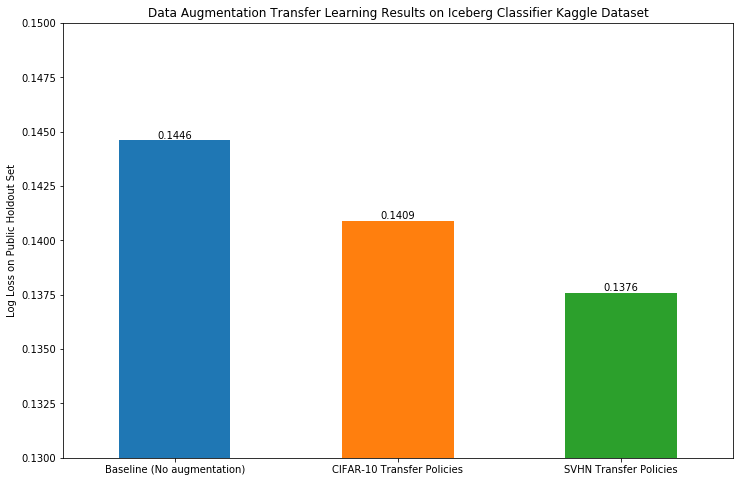

In [32]:
models = ['Baseline (No augmentation)', 'CIFAR-10 Transfer Policies', 'SVHN Transfer Policies']



log_losses = [0.1446,0.1409, 0.1376]
model_series = pd.Series.from_array(log_losses)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = model_series.plot(kind='bar')
ax.set_title('Data Augmentation Transfer Learning Results on Iceberg Classifier Kaggle Dataset')

ax.set_ylabel('Log Loss on Public Holdout Set')
ax.set_xticklabels(models,rotation='horizontal')

plt.ylim(0.13,0.15)

rects = ax.patches

for rect, label in zip(rects, log_losses):
    height = rect.get_height()

    ax.text(rect.get_x() + rect.get_width() / 2, height , label,ha='center', va='bottom')

We observed that Iceberg images are low color variation because they are fairly artificial "images" that were generated from radar readings. Given this observation, the relatively small improvements from transferring CIFAR-10 policies (from 0.1446 to 0.1409) makes sense because those policies include many color-related augmentations such as Color, Brightness, AutoContrast, etc, as shown in Table 8 of the AutoAugment paper.  

On the other hand, the improvements from using SVHN augmentations are almost twice as big (0.1446 to 0.1376), which makes sense because the SVHN augmentations contain relatively more positional transformations like ShearX, ShearY, Invert, Rotate, etc, as shown in Table 9 of the AutoAugment paper.  



--- 

## Simplified (Random Search) AutoAugment Results

This strategy was inspired by random grid search for hyperparameter tuning.
The ”Random Search Controller” was run for 250 epochs and kept track of the best policies it found for CIFAR-10. 

In [ ]:
! cd ../random_search/; python run.py

The results of the run.py are written to log.txt


Logfile contains information about subpolicies used for each epoch. After each epoch, child accuracy is printed.

In [42]:
! head -18 "../random_search/log.txt"


Controller: Epoch 1 / 250
# Sub-policy 1
Operation  2 (P=0.900, M=0.450)
Operation  7 (P=1.000, M=0.778)
# Sub-policy 2
Operation  9 (P=0.100, M=7.111)
Operation 14 (P=0.800, M=0.089)
# Sub-policy 3
Operation  5 (P=0.700, M=0.556)
Operation 12 (P=0.000, M=1.500)
# Sub-policy 4
Operation  0 (P=0.100, M=0.300)
Operation  3 (P=0.400, M=-0.150)
# Sub-policy 5
Operation 12 (P=0.200, M=0.300)
Operation 14 (P=0.700, M=0.089)
-> Child accuracy: 0.419 (elaspsed time: 102s)


The policy that produced the best results was as follows:

- Sub-Policy 0 = (Brightness, 0.1, 1.9), (ShearX, 0.0, - 0.3)
- Sub-Policy 1 = (Invert, 0.7, 0.111), (Contrast, 0.5, 1.5)
- Sub-Policy 2 = (Invert, 0.3, 0.667), (Color, 0.5, 1.7)]
- Sub-Policy 4 = (Rotate, 1.0, 0.778), (ShearY, 0.3, - 0.45)
- Sub-Policy 5 = (Brightness, 0.1, 1.5), (Invert, 0.9, 0.889)

Next, we tested the Random Search policies above by using them during training of a Wide-ResNet-28-10 model on the CIFAR-10 dataset.  We used the code base from the original AutoAugment implementation, and simply replaced the Reinforcement Learning policies with the Random Search policies (see original_autoaugment_implementation/policies.py).  



In [37]:
! cd ../original_autoaugment_implementation; python train_cifar.py --model_name=wrn \
                       --checkpoint_dir=/tmp/training \
                       --data_path=data/cifar-10-batches-py \
                       --dataset='cifar10' \
                       --use_cpu=0


<previous output truncated>
INFO:tensorflow:Restoring parameters from /tmp/training/model/model.ckpt-199
INFO:tensorflow:Loaded child model checkpoint from /tmp/training/model/model.ckpt-199
INFO:tensorflow:model.batch_size is 25
INFO:tensorflow:Eval child model accuracy: 0.966199994087
INFO:tensorflow:Test Accuracy: 0.966199994087
INFO:tensorflow:Train Acc: None    Valid Acc: 0.0     Test Acc: 0.966199994087


The chart below shows the comparison between the accuracy of he Wide-ResNet-28-10 model on CIFAR-10 (with no augmentation), trained with Random Search AutoAugment, and trained with original Reinforcement Learning AutoAugment augmentations.

/home/quocnle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  after removing the cwd from sys.path.


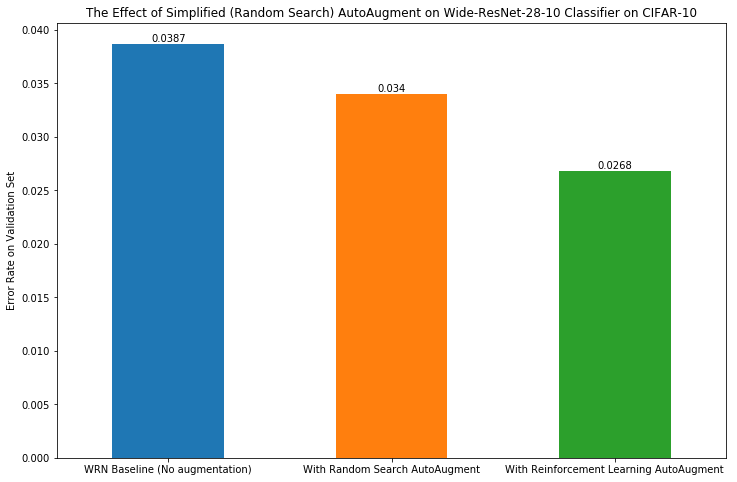

In [40]:
models = ['WRN Baseline (No augmentation)', 'With Random Search AutoAugment', 'With Reinforcement Learning AutoAugment']

error_rates = [0.0387,0.034, 0.0268]
model_series = pd.Series.from_array(error_rates)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = model_series.plot(kind='bar')
ax.set_title('The Effect of Simplified (Random Search) AutoAugment on Wide-ResNet-28-10 Classifier on CIFAR-10')

ax.set_ylabel('Error Rate on Validation Set')
ax.set_xticklabels(models,rotation='horizontal')

rects = ax.patches

for rect, label in zip(rects, error_rates):
    height = rect.get_height()

    ax.text(rect.get_x() + rect.get_width() / 2, height , label,ha='center', va='bottom')

Our observation here is that the Simplified "Random Search" AutoAugment (0.034 error) cannot beat the Reinforcement Learning approach from the original AutoAugment paper (0.0268), but it can improve on the WRN baseline (0.0387).  This suggests that Random Search AutoAugment could serve as a practical alternative to the Reinforcement Learning approach, and it can find good policies with a much simpler approach and much less search time.  